In [ ]:
import os
import numpy as np
import pandas as pd
import torch 
from torchvision.io import read_image
from torch.utils.data import Dataset
from torchvision.io import read_image
from PIL import Image
import torchvision.transforms as T
import matplotlib.pyplot as plt
import seaborn as sns
import random
BASE_PATH = "/content/drive/MyDrive/Colab Notebooks/crapaud/"
def from_class_to_yolo_cat(class_name) -> torch.int8:
            if class_name == "triton":
                return 1
            elif class_name == "grenouille-crapaud":
                return 2
            #elif class_name == "planche":
             #   return 3
            #elif class_name == "feuille":
            #    return 4
            elif class_name == "souris":
                return 3
            #elif class_name == "insect":
            #    return 6
            #elif class_name == "plastic":
            #    return 7
            #elif class_name == "oiseau":
            #    return 8
            else:
                print(class_name)
                return -1 # error


class CrapaudSet(Dataset):
    def __preproccessing(self, df_annotation : pd.DataFrame) -> pd.DataFrame:
        
        df_annotation['x1'] = df_annotation['top_left_x']
        df_annotation['y1'] = df_annotation['top_left_y'] 
        df_annotation['x2'] = df_annotation['top_left_x'] + df_annotation['w']
        df_annotation['y2'] = df_annotation['top_left_y'] + df_annotation['h']
        # We take the classses 
        subset_c1 = df_annotation[df_annotation['class'] == "triton"].iloc[:225,:]
        subset_c2 = df_annotation[df_annotation['class'] == "grenouille-crapaud"].iloc[:200,:]
#        subset_c4 = df_annotation[df_annotation['class'] == 4].iloc[:200,:]
        subset_c5 = df_annotation[df_annotation['class'] == "souris"].iloc[:197,:]
        res = pd.concat([subset_c1, subset_c2, subset_c5])
        res['class'] = res['class'].apply(from_class_to_yolo_cat)
        #return df_annotation
        return res

    def __init__(self, annotations_file : str, img_dir : str, transform=False):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.data_augmentation = transform
        self.img_labels = self.__preproccessing(self.img_labels)
        self.unique_paths = self.img_labels['path'].unique()
        transforms = []
        transforms.append(T.ToTensor())
        transforms.append(T.ConvertImageDtype(torch.float))
        self.trans = T.Compose(transforms)

    def __len__(self):
        return len(self.img_labels['path'].unique())

    def __rotate__(image,bonding_box_coordinate):
        
        angle = random.randint(-30, 30)
        image = T.functional.rotate(image, angle)
        bonding_box_coordinate = T.functional.rotate(bonding_box_coordinate, angle)
        return image,bonding_box_coordinate
     
    def __getitem__(self, idx):
        # We can have multiple labels for one image therefore we take the unique paths 
        # and get all the labels associated with it
        
        # get the image path
        path = self.unique_paths[idx]
        img_path = os.path.join(self.img_dir, path)
        img = Image.open(img_path).convert("RGB")
        
        # select all the labels for the image
        labels = self.img_labels[self.img_labels['path'] == path]
        # get the bounding boxe(S), there might be multiple !!
        boxes_np = labels[['x1', 'y1', 'x2', 'y2']].values
        labels_np = labels['class'].values
        # create the target dict 
        target = {}
        target['boxes'] = torch.as_tensor(boxes_np, dtype=torch.float32)
        target['labels'] = torch.as_tensor(labels_np, dtype=torch.int64)
        target['image_id'] = torch.tensor([idx])
        target['iscrowd'] = torch.zeros((len(boxes_np),), dtype=torch.int64)
        area = [(box[2]-box[0]) * (box[3]-box[1]) for box in boxes_np]
        target['area'] = torch.tensor(area)
        img = self.trans(img)
        if self.data_augmentation:
            #doesn't work on the bounding box need to investigate
            #img,target = CrapaudSet.__rotate__(img, target['boxes'])
            gammas = [0.5, 0.6, 0.7, 0.75, 0.8]
            i = random.randint(0,len(gammas)-1)
            img = T.functional.adjust_gamma(img, gamma=gammas[i])
        
        return img, target

In [ ]:
import os
import torchvision
import torch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision.transforms as T
from google.colab import drive


drive.mount("/content/drive",force_remount=True)


Mounted at /content/drive


In [ ]:
!rm coco* engine.py transforms.py utils.py
!true

rm: cannot remove 'coco*': No such file or directory
rm: cannot remove 'engine.py': No such file or directory
rm: cannot remove 'transforms.py': No such file or directory
rm: cannot remove 'utils.py': No such file or directory


In [ ]:
%%shell

# Download TorchVision repo to use some files from
# references/detection

git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.8.2

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../


Cloning into 'vision'...
remote: Enumerating objects: 261952, done.
remote: Counting objects: 100% (1151/1151), done.
remote: Compressing objects: 100% (604/604), done.
remote: Total 261952 (delta 1056), reused 592 (delta 545), pack-reused 260801
Receiving objects: 100% (261952/261952), 527.29 MiB | 23.43 MiB/s, done.
Resolving deltas: 100% (238801/238801), done.
Note: checking out 'v0.8.2'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at 2f40a483d [v0.8.X] .circleci: Add Python 3.9 to CI (#3063)


In [ ]:


def get_instance_model(num_classes = 5):
    # num_classes which is user-defined
    
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(weights="DEFAULT")
    for param in model.parameters():
      param.requires_grad = False
    # replace the classifier with a new one, that has
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    return model


model = get_instance_model()

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth


  0%|          | 0.00/167M [00:00<?, ?B/s]

In [ ]:
def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    transforms.append(T.ConvertImageDtype(torch.float))
    if train:
      pass
       # transforms.append(T.RandomVerticalFlip())
       # transforms.append(T.RandomAffine(90,scale=(1,1.5)))
       # transforms.append(T.ConvertImageDtype(torch.uint8))
       # transforms.append(T.AutoAugment(T.AutoAugmentPolicy.IMAGENET))
       # transforms.append(T.ConvertImageDtype(torch.float))
    return T.Compose(transforms)
def collate_fn(batch):
    return tuple(zip(*batch))


In [ ]:
from engine import train_one_epoch, evaluate
#from torch.utils.tensorboard import SummaryWriter
import utils

#writer = SummaryWriter('runs/triton_train')
loggers = []
coco_evals = []
def main():
    # train on the GPU or on the CPU, if a GPU is not available
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    # use our dataset and defined transformations
    dataset = CrapaudSet(BASE_PATH + "path_and_bounding_box.csv",BASE_PATH+"subset", True)
    dataset_test = CrapaudSet(BASE_PATH+"path_and_bounding_box.csv",BASE_PATH+"subset", False)

    # split the dataset in train and test set
    indices = torch.randperm(len(dataset)).tolist()
    dataset = torch.utils.data.Subset(dataset, indices[:-75])
    dataset_test = torch.utils.data.Subset(dataset_test, indices[-75:])

    # define training and validation data loaders
    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=8, shuffle=True, num_workers=2,
        collate_fn=utils.collate_fn)

    data_loader_test = torch.utils.data.DataLoader(
        dataset_test, batch_size=8, shuffle=False, num_workers=2,
        collate_fn=utils.collate_fn)

    # get the model using our helper function
    model = get_instance_model()

    # move model to the right device
    model.to(device)

    # construct an optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.Adam(params, lr=0.005,
                          weight_decay=0.0005)
    # and a learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=3,
                                                   gamma=0.1)

    # let's train it for 10 epochs
    num_epochs = 15

    for epoch in range(num_epochs):
        # train for one epoch, printing every 10 iterations
        logger = train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
        loggers.append(logger)
        # update the learning rate
        lr_scheduler.step()
        # evaluate on the test dataset
        coco_evaluator = evaluate(model, data_loader_test, device=device)
        coco_evals.append(coco_evaluator)

    print("That's it!")

In [ ]:
  main()

Epoch: [0]  [ 0/69]  eta: 0:16:25  lr: 0.000078  loss: 1.4383 (1.4383)  loss_classifier: 1.3304 (1.3304)  loss_box_reg: 0.0864 (0.0864)  loss_objectness: 0.0191 (0.0191)  loss_rpn_box_reg: 0.0023 (0.0023)  time: 14.2807  data: 7.0918  max mem: 4089
Epoch: [0]  [10/69]  eta: 0:02:30  lr: 0.000813  loss: 1.1654 (1.1079)  loss_classifier: 1.0523 (0.9907)  loss_box_reg: 0.0667 (0.0644)  loss_objectness: 0.0467 (0.0491)  loss_rpn_box_reg: 0.0029 (0.0037)  time: 2.5590  data: 1.6839  max mem: 4089
Epoch: [0]  [20/69]  eta: 0:01:46  lr: 0.001548  loss: 0.4598 (0.7214)  loss_classifier: 0.3377 (0.6067)  loss_box_reg: 0.0592 (0.0630)  loss_objectness: 0.0439 (0.0484)  loss_rpn_box_reg: 0.0029 (0.0034)  time: 1.5681  data: 1.3249  max mem: 4089
Epoch: [0]  [30/69]  eta: 0:01:18  lr: 0.002282  loss: 0.2478 (0.5661)  loss_classifier: 0.1360 (0.4546)  loss_box_reg: 0.0555 (0.0598)  loss_objectness: 0.0413 (0.0480)  loss_rpn_box_reg: 0.0033 (0.0036)  time: 1.7287  data: 1.4858  max mem: 4089
Epoch: 

In [ ]:
print(loggers[0].__dict__)

{'meters': defaultdict(<class 'utils.SmoothedValue'>, {'lr': <utils.SmoothedValue object at 0x7f72c62cfb80>, 'loss': <utils.SmoothedValue object at 0x7f72c62cfc10>, 'loss_classifier': <utils.SmoothedValue object at 0x7f72c6341220>, 'loss_box_reg': <utils.SmoothedValue object at 0x7f72c63411c0>, 'loss_objectness': <utils.SmoothedValue object at 0x7f72c6341040>, 'loss_rpn_box_reg': <utils.SmoothedValue object at 0x7f72c6341f10>}), 'delimiter': '  '}


In [ ]:
avg_losses = []
med_losses = []
avg_loss_classifier = []
med_loss_classifier = []
avg_loss_box_reg = []
med_loss_box_reg = []
for i in range(len(loggers)):
  avg = loggers[i].loss.avg
  med = loggers[i].loss.median
  avg_losses.append(avg)
  med_losses.append(med)

  avg = loggers[i].loss_classifier.avg
  med = loggers[i].loss_classifier.median
  avg_loss_classifier.append(avg)
  med_loss_classifier.append(med)

  avg_box = loggers[i].loss_box_reg.avg
  med_box = loggers[i].loss_box_reg.median
  avg_loss_box_reg.append(avg_box)
  med_loss_box_reg.append(med_box)
  
from io import StringIO
import sys


import io
from contextlib import redirect_stdout
outer = ""
with io.StringIO() as buf, redirect_stdout(buf):
  for i in range(len(coco_evals)):
    coco_evals[i].coco_eval['bbox'].summarize()    
  outer = buf.getvalue()

lines = outer.split('\n')
avg_precision_iou50 = []
avg_precision_iou75 = []
avg_recall_iou50_90 = []
for i in range(len(coco_evals)):
  #...'-1.000' or ...' 0.482' (note the space) are stripped of whitespace then 
  # converted to float
  #for 1 epoch we have 12 line therefore we take i*12

  avg_precision_iou50.append(float((lines[i*12 + 1][-5:]).strip()))
  avg_precision_iou75.append(float((lines[i*12 + 2][-5:]).strip()))
  avg_recall_iou50_90.append(float((lines[i*12 + 8][-5:]).strip()))



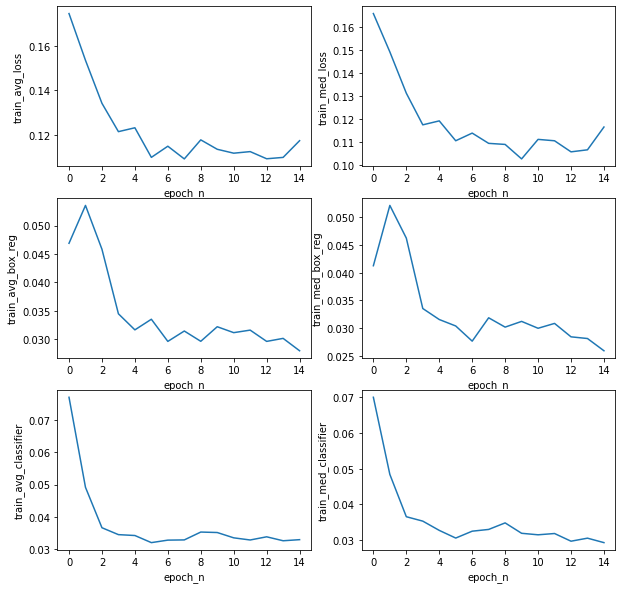

In [ ]:
fig, ax = plt.subplots(3,2,figsize=(10,10))
ax = ax.ravel()


df = pd.DataFrame({
    "epoch_n":range(0,len(loggers)), 
    "train_avg_loss": avg_losses,
    "train_med_loss":med_losses,
    "train_avg_box_reg":avg_loss_box_reg,
    "train_med_box_reg":med_loss_box_reg,
    "train_avg_classifier":avg_loss_classifier,
    "train_med_classifier":med_loss_classifier,
    "test_avg_precision_iou50":avg_precision_iou50,
    "test_avg_precision_iou75":avg_precision_iou75,
    "test_avg_recall_iou50_90":avg_recall_iou50_90
    })

sns.lineplot(data=df,x='epoch_n',y='train_avg_loss', ax=ax[0])
sns.lineplot(data=df,x='epoch_n',y='train_med_loss', ax=ax[1])# ,kwargs={"suptitle":"train_med_loss"})
sns.lineplot(data=df,x='epoch_n',y='train_avg_box_reg', ax=ax[2])#, kwargs={"suptitle":"train_avg_rpn_box"})
sns.lineplot(data=df,x='epoch_n',y='train_med_box_reg', ax=ax[3])#, kwargs={"suptitle":"train_med_rpn_box"})
sns.lineplot(data=df,x='epoch_n',y='train_avg_classifier', ax=ax[4])#, kwargs={"suptitle":"train_avg_rpn_box"})
sns.lineplot(data=df,x='epoch_n',y='train_med_classifier', ax=ax[5])#, kwargs={"suptitle":"train_med_rpn_box"})


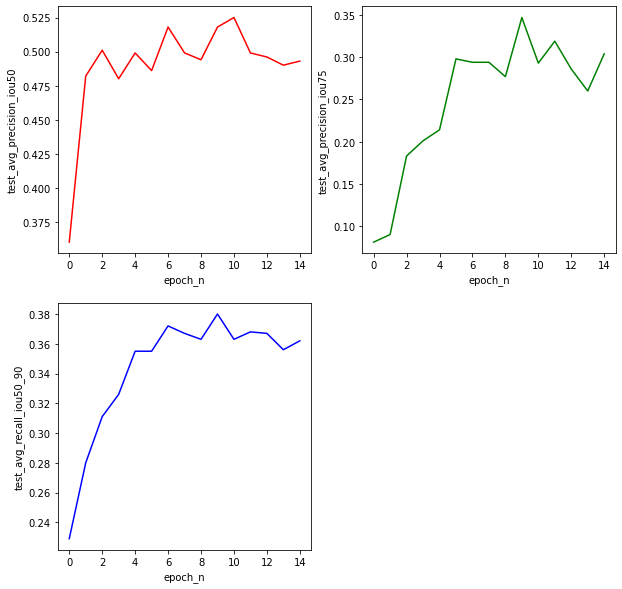

In [ ]:
fig,ax = plt.subplots(2,2,figsize=(10,10))
ax = ax.ravel()
sns.lineplot(data=df,x="epoch_n",y='test_avg_precision_iou50',ax=ax[0],color="red")
sns.lineplot(data=df,x="epoch_n",y='test_avg_precision_iou75',ax=ax[1],color="green")
sns.lineplot(data=df,x="epoch_n",y='test_avg_recall_iou50_90',ax=ax[2],color="blue")
fig.delaxes(ax[3])

In [ ]:
lines[12][-5:]

'0.206'

In [ ]:
#lines = output.split("\n")
#lines[0]

In [ ]:
torch.save(model, "/content/drive/MyDrive/Colab Notebooks/crapaud/model.pt")

#model_scripted = torch.jit.script(model) # Export to TorchScript
#model_scripted.save('/content/drive/MyDrive/Colab Notebooks/crapaud/model_torchscript.pt') # Save

In [ ]:
#model = torch.load("/content/drive/MyDrive/Colab Notebooks/crapaud/model.pt")

In [ ]:
#import matplotlib.pyplot as plt
#from PIL import Image
#device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

#img_pil = Image.open("/content/triton.jpeg").convert("RGB")
#img_tensor = T.ToTensor()(img_pil)
#model.eval()

#res = model([img_tensor])
#res

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

#img_pil = Image.open("/content/triton.jpeg").convert("RGB")
img_pil = Image.open(BASE_PATH+"triton.jpeg").convert("RGB")
img2 = Image.open(BASE_PATH+"triton.jpeg")

#print("Image data:", img2)
print("Is image a PyTorch Tensor:", torch.is_tensor(img2))
print("Type of Image:", type(img2))


img_tensor = T.ToTensor()(img_pil)

#print("Image data:", img_tensor)
print("Is image a PyTorch Tensor:", torch.is_tensor(img_tensor))
print("Type of Image:", type(img_tensor))

model.eval()
img_tensor = T.functional.adjust_gamma(img_tensor, gamma=0.6,)

res = model([img_tensor])
print(res)

bbox_t = res[0]['boxes'][0]
#bbox_t = bbox_t.int().to(torch.torch.uint8)
bbox_t = bbox_t.unsqueeze(0)
#bbox_t
img = torchvision.utils.draw_bounding_boxes(img_tensor.mul(255).int().to(torch.torch.uint8), bbox_t, width=2)

#res[0]['boxes']
#img = torchvision.utils.draw_bounding_boxes(img_tensor, bbox_t, width=2)
#img = img_tensor
img = T.ToPILImage()(img.to('cpu'))



Is image a PyTorch Tensor: False
Type of Image: <class 'PIL.JpegImagePlugin.JpegImageFile'>
Is image a PyTorch Tensor: True
Type of Image: <class 'torch.Tensor'>
[{'boxes': tensor([[8.8288e+02, 7.4197e+01, 1.1486e+03, 2.4675e+02],
        [8.2703e+01, 2.5380e+02, 7.1529e+02, 4.1869e+02],
        [0.0000e+00, 2.2357e+02, 6.9963e+02, 3.5753e+02],
        [0.0000e+00, 4.3693e+02, 5.4444e+02, 6.5644e+02],
        [2.4289e+02, 4.2893e+02, 1.1298e+03, 6.8857e+02],
        [7.4855e+02, 3.1757e+01, 1.1160e+03, 5.7250e+02],
        [4.3580e+02, 2.6381e+01, 9.9109e+02, 2.1272e+02],
        [6.0230e+02, 2.4035e+02, 1.1459e+03, 4.2596e+02],
        [6.7606e+02, 6.7815e+00, 1.1919e+03, 3.6196e+02],
        [5.1300e+02, 4.5576e+02, 1.1032e+03, 6.1297e+02],
        [7.3654e+01, 8.5312e+00, 1.0672e+03, 3.5784e+02],
        [3.0860e+02, 2.8660e+01, 1.0469e+03, 5.1706e+02],
        [0.0000e+00, 0.0000e+00, 9.5529e+02, 1.9640e+02],
        [6.1655e+01, 2.3813e+02, 3.1815e+02, 4.4914e+02],
        [7.8013

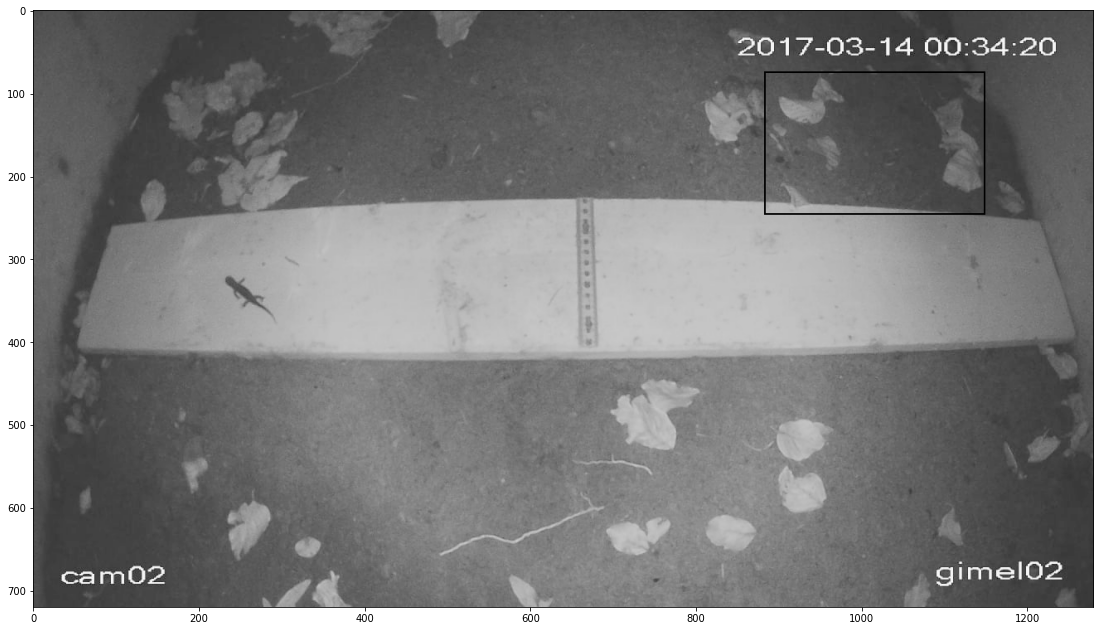

In [ ]:
fig, ax = plt.subplots(1,figsize=(19,11))#1920x1080
ax.imshow(img)